# Fitting a Gaussian Process exactly on the observed data

We want to make simulations that would better explain the results of figure 7. of the article, and could illustrate our interpretation of the distinction between the notion of flexibility and complexity the authors are describing. This notebook will only require numpy, matplotlib and pyro.

In [185]:
import numpy as np
import matplotlib.pyplot as plt

Let us recall that a Gaussian Process is fully specified by its mean function $\mu(x)$ and its kernel function $k(x,x')$.
We will consider gaussian processes with an RBF kernel: $k(x,x') = \sigma^2 \exp\left(-\gamma (x-x')^2 \right)$

In [186]:
def RBF(x, y, gamma = 1, sigma = 1):
    return sigma**2 * np.exp(-gamma*(x[:,np.newaxis] - y[np.newaxis,:])**2)

And assume that the possible mean functions are constant: $\mu(x;w) = w$

In [187]:
def mu(x, w):
    return np.array(w).repeat(x.shape)

Now the assumed model is that the observation are coming from white noise perturbation of these gaussian process:
$$
\begin{align*}
Y_{\mathrm{obs}}(x) &= Y_{\mathrm{GP}}(x) + \epsilon(x) \\
Y_{\mathrm{GP}}(x)|w &\sim \mathcal{N}(\mu(x;w), k(x,x')) \\
\epsilon(x) & \sim \mathcal{N}(0, \sigma_{\mathrm{mes}}^2 \delta(x,x')) \\
w &\sim \mathcal{N}(w_0, \sigma_0^2)
\end{align*}
$$

# Calibration of $w$

Let us now assume that we have observations $y_{\mathrm{obs}} = (Y_{\mathrm{obs}}(x_1),\dots,Y_{\mathrm{obs}}(x_n))$. The rest of the computation will be done with the implicit conditioning on $x_{\mathrm{obs}} = (x_1,\dots,x_n)$. Then we know that:
$$
y_{\mathrm{obs}} |w \sim \mathcal{N}(w \mathbf{1}_n, K_{\mathrm{obs}} + \sigma_{\mathrm{mes}}^2 I_n)
$$
where $K_{\mathrm{obs}}$ is the Gram matrix $(k(x_i,x_j))_{1 \leq i,j \leq n}$ and $\mathbf{1}_n = (1)_{1 \leq j \leq n}$. Let us define $R = K_{\mathrm{obs}} + \sigma_{\mathrm{mes}}^2 I_n$.

We can then compute the probability of the posterior
$$
p(w|y_{\mathrm{obs}}) \propto p(w) p(y_{\mathrm{obs}}|w)
$$
is gaussian because of the gaussian prior. It suffices to identify the element of the quadratic form:
$$
\begin{align*}
p(w|y_{\mathrm{obs}}) &\propto \exp\left(-\frac{1}{2\sigma_0^2}(w-w_0)^2 - \frac{1}{2}(y_{\mathrm{obs}} - w\mathbf{1}_n)^TR^{-1}(y_{\mathrm{obs}} - w \mathbf{1}_n)\right) \\
&\propto \exp\left(-\frac{1}{2(\sigma_0^{-2} + \mathbf{1}_n^T R^{-1}\mathbf{1}_n)^{-1}}
     \left(w - w_0 - (\sigma_0^{-2} + \mathbf{1}_n^T R^{-1}\mathbf{1}_n)^{-1}\mathbf{1}_n^T R^{-1}(y_{\mathrm{obs}}-w_0\mathbf{1}_n)\right)^2\right)
\end{align*}
$$
We can therefore conclude that 
$$
\begin{align*}
w_{\mathrm{post}} &= w_0 + \sigma_{\mathrm{post}}^2\mathbf{1}_n^T R^{-1}(y_{\mathrm{obs}}-w_0\mathbf{1}_n) \\
\sigma_{\mathrm{post}}^2 &= (\sigma_0^{-2} + \mathbf{1}_n^T R^{-1}\mathbf{1}_n)^{-1}
\end{align*}
$$

# Prediction given $w_{\mathrm{post}}$

Assume we want to predict a new value $Y_{\mathrm{obs}}(x)$ for a new value $x$. If we keep the measurement error, it can technically be the same as one of the elements of $x_{\mathrm{obs}} = (x_1,\dots,x_n)$.

We know that 
$$
\begin{pmatrix}
y_{\mathrm{obs}} \\
y
\end{pmatrix} \big | w 
\sim
\mathcal{N}\left(
\begin{pmatrix}
    w \mathbf{1}_n\\
    w
\end{pmatrix},
\begin{pmatrix}
    R & r(x) \\
    r(x)^T & \tilde{\sigma}^2
\end{pmatrix}
\right)
$$
where $r(x) = (k(x,x_j) + \sigma_{\mathrm{mes}}^2 \mathbf{1}(x = x_j))_{1 \leq j \leq n}$ and $\tilde{\sigma}^2 = \sigma^2 + \sigma_{\mathrm{mes}}^2$.

So we can similarly compute $p(y , w|y_{\mathrm{obs}}) \propto p(w) p(y_{\mathrm{obs}}, y | w)$ which will also be a gaussian.
The Bayesian Model Averaging computation we are interested in is 
$$p(y|y_{\mathrm{obs}}) = \int p(y,w|y_{\mathrm{obs}}) dw$$

We finally obtain a gaussian posterior with parameters:
$$
\begin{align*}
    y_{\mathrm{post}}(x) &= w_{\mathrm{post}} + r(x)^T R^{-1}(y_{\mathrm{obs}} - w_{\mathrm{post}} \mathbf{1}_n)\\
    \mathrm{Var}(y_{\mathrm{post}}(x)) &= \tilde{\sigma}^2 -
    \begin{pmatrix}
    1 \\
    r(x) \\
    \end{pmatrix}^T
    \begin{pmatrix}
    - \sigma_0^{-2} & \mathbf{1}_n^T \\
    \mathbf{1}_n & R
    \end{pmatrix}^{-1}
    \begin{pmatrix}
    1 \\
    r(x) \\
    \end{pmatrix}
\end{align*}
$$

# Example

We will use a function similar to the article: $y(x) = \sin(2 \pi x) + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma_{\mathrm{func}}^2), \sigma_{\mathrm{func}} = 0.2$.
Then we will generate some observation points:

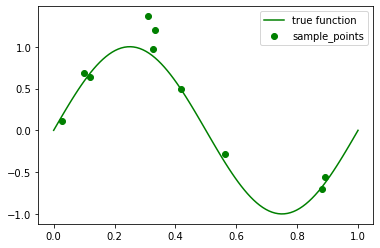

In [188]:
sigma_func = 0.2
def Y_true(x):
    return np.sin(x*2*np.pi)

sample_space = np.linspace(0,1,100)
nb_correct_points = 10
X = np.random.uniform(size = nb_correct_points)
Y = Y_true(X) + sigma_func*np.random.normal(size = nb_correct_points)

plt.scatter(X, Y, c = 'green', label = 'sample_points')
plt.plot(sample_space, Y_true(sample_space), c = 'green', label = 'true function')
plt.legend()
plt.show()

Now, we will calibrate our model and use it to predict the function:

In [189]:
gamma = 1
sigma = 1
kernel = lambda x, y: RBF(x, y, gamma = gamma, sigma = sigma)
kernel_univariate = lambda x : sigma**2 * np.exp(-gamma*x**2)

In [190]:
sigma_mes = 0.05
w_0 = 0
sigma_0 = 1

def calibrate(x_obs, y_obs, w_0 = w_0, sigma_0 = sigma_0, sigma_mes = sigma_mes, kernel = kernel):
    """
    Calibration script for determining w_post, sigma_post, will also output R and R^{-1} for convenience
    """
    R = kernel(x_obs, x_obs) + sigma_mes**2 * np.eye(x_obs.size)
    R_inv = np.linalg.inv(R)
    
    sigma_post = np.sqrt((1/sigma_0**2 + np.sum(R_inv))**(-1))
    w_post = w_0 + sigma_post**2 * np.dot(np.sum(R_inv, axis = 0), y_obs - w_0)
    
    return w_post, sigma_post, R, R_inv

In [191]:
def predict(x, x_obs, y_obs, kernel = kernel, kernel_univariate = kernel_univariate,
            sigma_0 = sigma_0, sigma_mes = sigma_mes):
    """
    Prediction script for determining y_post, var(y_post) at positions x, given x_obs, y_obs.
    """
    w_post, sigma_post, R, R_inv = calibrate(x_obs, y_obs, w_0 = w_0, sigma_0 = sigma_0,
                                             sigma_mes = sigma_mes, kernel = kernel)
    y_post = w_post + kernel(x, x_obs) @ R_inv @ (y_obs - w_post)
    
    R_pred = np.vstack([np.ones(x.size), kernel(x_obs, x)])
    central_block = np.linalg.inv(
        np.block([[-1/sigma_0**2, np.ones(x_obs.size)[np.newaxis,:]], 
                  [np.ones(x_obs.size)[:,np.newaxis], R]])
    )
    var_post = kernel_univariate(0) + sigma_mes**2 - np.einsum('ji, jk, ki -> i', R_pred, central_block, R_pred)
    return y_post, var_post

In [192]:
def sample_gp(x, w, kernel = kernel):
    """
    Gaussian Process sampling script used to show prior samples
    """
    return np.random.multivariate_normal(mean = mu(x, w), cov = kernel(x, x))

We will now plot some prior samples from the distribution $p(f(x;w))$ induced by our prior $p(w)$ and our model. As we can see, the functions are a priori very smooth and without much oscillations.

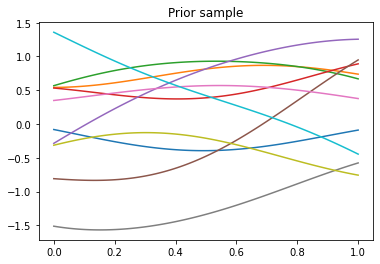

In [193]:
nb_samples = 10
for k in range(nb_samples):
    w = np.random.normal(loc = w_0, scale = sigma_0)
    plt.plot(sample_space, sample_gp(sample_space, w))
plt.title('Prior sample')
plt.show()

Now we can try to compute the infered function of our model

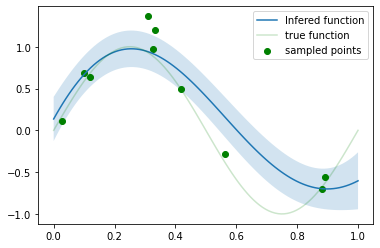

In [194]:
Y_post, var_post = predict(sample_space, X, Y)

plt.plot(sample_space, Y_post, label = 'Infered function')
plt.fill_between(sample_space, Y_post - 3.96*np.sqrt(var_post), Y_post + 3.96*np.sqrt(var_post), alpha = 0.2)
plt.scatter(X, Y, c = 'green', label = 'sampled points')
plt.plot(sample_space, Y_true(sample_space), c = 'green', label = 'true function', alpha = 0.2)
plt.legend()
plt.show()

The function that we had to infere was quite simple, so the Gaussian Process Regression had actually not much trouble in distorting itself to fit the sample points.

## Adding noise points

We will now add new observation points that are unrelated to the original functions:
$y_{\mathrm{noise}} \sim \mathcal{U}(0.5,1)$

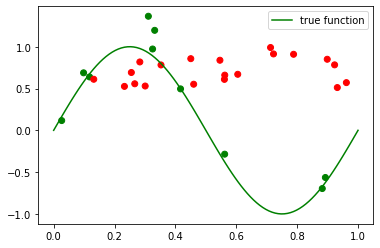

In [195]:
nb_noise_points = 20
X_noise = np.random.uniform(size = nb_noise_points)
Y_noise = np.random.uniform(low = 0.5, high = 1.0, size = nb_noise_points)

X_full = np.hstack([X, X_noise])
Y_full = np.hstack([Y, Y_noise])

plt.scatter(X_full, Y_full, c = ['green']*X.size + ['red']*X_noise.size)
plt.plot(sample_space, Y_true(sample_space), c = 'green', label = 'true function')
plt.legend()
plt.show()

Using the same kernel, we can try to fit the new data.

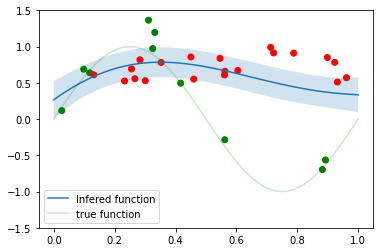

In [196]:
Y_post, var_post = predict(sample_space, X_full, Y_full)

plt.plot(sample_space, Y_post, label = 'Infered function')
plt.fill_between(sample_space, Y_post - 3.96*np.sqrt(var_post), Y_post + 3.96*np.sqrt(var_post), alpha = 0.2)
plt.scatter(X_full, Y_full, c = ['green']*X.size + ['red']*X_noise.size)
plt.plot(sample_space, Y_true(sample_space), c = 'green', label = 'true function', alpha = 0.2)
plt.legend()
plt.ylim(-1.5,1.5)
plt.show()

We can see that it doesn't really fit, the thing is that the only parameter calibrated is $w$: with a fixed $\gamma = 1$ and $\sigma = 1$, the model will only assume that the function has a very smooth behavior. From a true bayesian perspective, it could be possible to give priors to the currently fixed hyperparameters of the kernel as well as the measurement noise and see what would be the posterior. Unfortunately, it is likely that this posterior is not computable in an analytic way just like our previous computations.

To show that the model is in fact very flexible and can perfectly fit this new function, we will need to adjust the kernel.

In [197]:
gamma = 1000
sigma = 10
kernel = lambda x, y: RBF(x, y, gamma = gamma, sigma = sigma)
kernel_univariate = lambda x : sigma**2 * np.exp(-gamma*x**2)

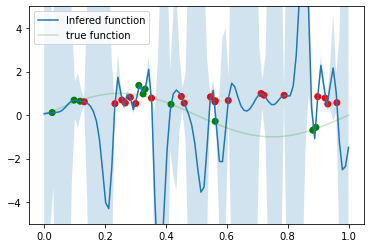

In [198]:
Y_post, var_post = predict(sample_space, X_full, Y_full)

plt.plot(sample_space, Y_post, label = 'Infered function')
plt.fill_between(sample_space, Y_post - 1.96*np.sqrt(var_post), Y_post + 1.96*np.sqrt(var_post), alpha = 0.2)
plt.scatter(X_full, Y_full, c = ['green']*X.size + ['red']*X_noise.size)
plt.plot(sample_space, Y_true(sample_space), c = 'green', label = 'true function', alpha = 0.2)
plt.legend()
plt.ylim(-5,5)
plt.show()

The previous plot shows that there exists some hyperparameters $\gamma$ and $\sigma$ that are allowing the model to perfectly fit on the training set.
This corresponds to the idea that the support of Gaussian Process Regression is quite large, ie. that the model is very flexible.

# Using Pyro

Now, in order to take into account the observation that previously, the model had fixed $\gamma$ and $\sigma$, we will use Pyro in order to optimize them and do a proper Gaussian Process fitting (which is likely what was intended by the article).

In [116]:
!pip install pyro-ppl

The functions are based on the following example: https://pyro.ai/examples/gp.html

In [199]:
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

Very similarly, we define the RBF kernel as well as the Gaussian Process Regression.

In [208]:
sigma = 1
gamma = 1

kernel = gp.kernels.RBF(input_dim = 1, variance = torch.tensor(sigma**2), lengthscale = torch.tensor(np.sqrt(1/(2*gamma))))

gpr = gp.models.GPRegression(torch.from_numpy(X), torch.from_numpy(Y), kernel, noise = torch.tensor(sigma_mes))

In [209]:
def plot_gpr(plot_observed_data=False, X = X, Y = Y, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):
    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.scatter(X, Y, c = 'green')
    if plot_predictions:
        Xtest = torch.linspace(0., 1., n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest.double(), full_cov=True)
            else:
                mean, cov = model(Xtest.double(), full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'blue', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 1.96 * sd).numpy(),
                         (mean + 1.96 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(0., 1., n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(0, 1)

Now we will start the optimizing steps: 

In [213]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

We can plot some functions from the prior we get (RBF kernel + white noise).

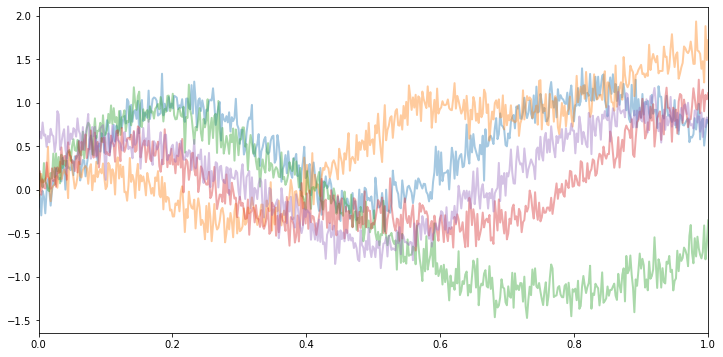

In [214]:
plot_gpr(model=gpr, kernel=kernel, n_prior_samples=5)

And we can also verify that loss did decrease.

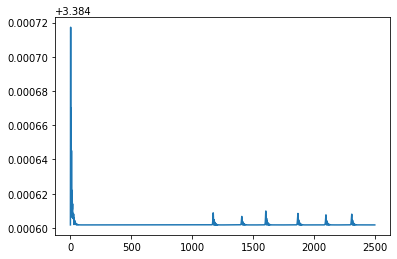

In [215]:
plt.plot(losses)
plt.show()

Here we obtain the final predictions of Pyro, very similar to those of the article.

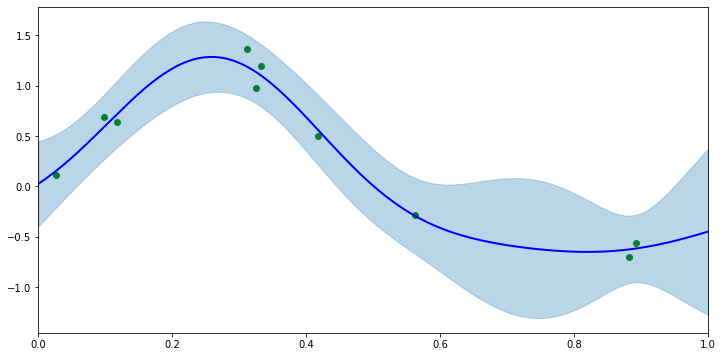

In [216]:
plot_gpr(model=gpr, plot_observed_data=True, plot_predictions=True)

# Noisy data

Now we can try to reproduce the same thing with the noisy dataset.

In [217]:
kernel = gp.kernels.RBF(input_dim = 1, variance = torch.tensor(sigma**2), lengthscale = torch.tensor(np.sqrt(1/(2*gamma))))

gpr = gp.models.GPRegression(torch.from_numpy(X_full), torch.from_numpy(Y_full), kernel, noise = torch.tensor(sigma_mes))

In [226]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 # should be rerun multiple times, in order to have a loss sufficiently small
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

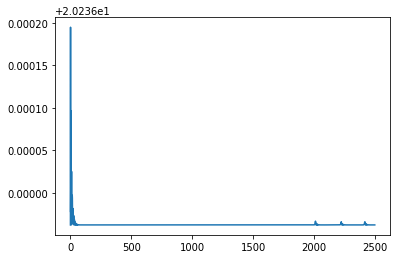

In [227]:
plt.plot(losses)
plt.show()

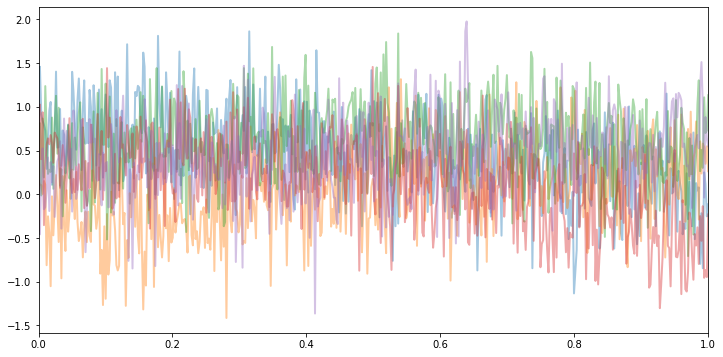

In [228]:
plot_gpr(model=gpr, kernel=kernel, n_prior_samples=5)

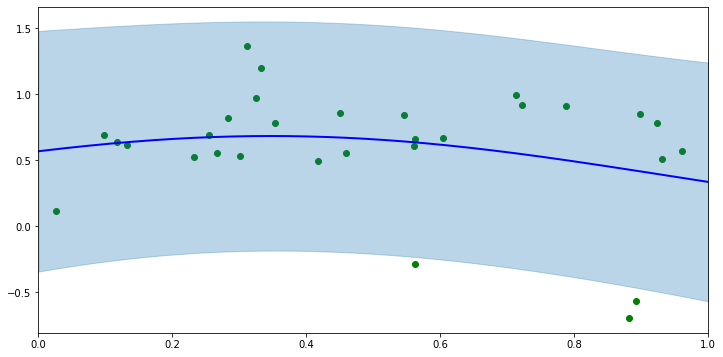

In [229]:
plot_gpr(model=gpr, X=X_full, Y=Y_full, plot_observed_data=True, plot_predictions=True)

Even with a lot of training steps, in practice, the GPR won't overfit on this noisy dataset, the model does not select the hyperparameters seen previously. This would correspond to the idea that the model has inductive biases towards simple functions.